In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:
# True ODE dynamics
gamma = 0.5
omega = 2

def damped_oscillator(t, y):
    x, v = y
    dxdt = v
    dvdt = -2 * gamma * v - omega**2 * x
    return np.array([dxdt, dvdt])

# High-resolution time for testing
t_test = np.linspace(0, 10, 100)
dt = t_test[1] - t_test[0]

# Simulate true dynamics
y = np.zeros((len(t_test), 2))
y[0] = [1.0, 0.0]  # initial condition

for i in range(1, len(t_test)):
    y[i] = y[i-1] + damped_oscillator(t_test[i-1], y[i-1]) * dt

# Training subset (first 10 points from t ∈ (0, 2))
t_train = t_test[:40]
y_train = y[:40]

# Convert to tensors
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

t_test_tensor = torch.tensor(t_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y, dtype=torch.float32).to(device)

print("Y_train:", y_train_tensor)
print("T_train:", t_train_tensor)


Y_train: tensor([[ 1.0000,  0.0000],
        [ 1.0000, -0.4040],
        [ 0.9592, -0.7673],
        [ 0.8817, -1.0773],
        [ 0.7729, -1.3247],
        [ 0.6391, -1.5032],
        [ 0.4872, -1.6096],
        [ 0.3246, -1.6438],
        [ 0.1586, -1.6090],
        [-0.0039, -1.5105],
        [-0.1565, -1.3563],
        [-0.2935, -1.1561],
        [-0.4103, -0.9207],
        [-0.5033, -0.6620],
        [-0.5702, -0.3917],
        [-0.6097, -0.1218],
        [-0.6220,  0.1368],
        [-0.6082,  0.3744],
        [-0.5704,  0.5823],
        [-0.5116,  0.7539],
        [-0.4354,  0.8845],
        [-0.3461,  0.9711],
        [-0.2480,  1.0128],
        [-0.1457,  1.0107],
        [-0.0436,  0.9675],
        [ 0.0541,  0.8874],
        [ 0.1438,  0.7759],
        [ 0.2221,  0.6394],
        [ 0.2867,  0.4851],
        [ 0.3357,  0.3202],
        [ 0.3681,  0.1522],
        [ 0.3834, -0.0118],
        [ 0.3822, -0.1656],
        [ 0.3655, -0.3033],
        [ 0.3349, -0.4203],
        [ 0

In [ ]:
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, t, y):
        return self.net(y)


In [14]:
def compute_physics_residual(func, t, y0):
    y = odeint(func, y0, t, method='dopri5')  # (T, 2)
    
    x = y[:, 0]
    v = y[:, 1]

    dxdt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    dvdt = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    residual = dvdt + 2 * gamma * v + omega**2 * x
    return torch.mean(residual**2)

func = ODEFunc().to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Enable gradients w.r.t time
t_train_tensor.requires_grad_(True)


import time

start_time = time.time()
for epoch in range(900):
    optimizer.zero_grad()
    
    pred = odeint(func, y_train_tensor[0], t_train_tensor, method='dopri5')
    loss_data = loss_fn(pred, y_train_tensor)

    loss_phy = compute_physics_residual(func, t_train_tensor, y_train_tensor[0])

    loss = loss_data + 0.1 * loss_phy
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Data Loss = {loss_data.item():.6f} | Physics Loss = {loss_phy.item():.6f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch    0 | Data Loss = 0.895882 | Physics Loss = 15.984421
Epoch  100 | Data Loss = 0.123272 | Physics Loss = 0.539014
Epoch  200 | Data Loss = 0.020066 | Physics Loss = 0.125871
Epoch  300 | Data Loss = 0.018955 | Physics Loss = 0.090709


KeyboardInterrupt: 

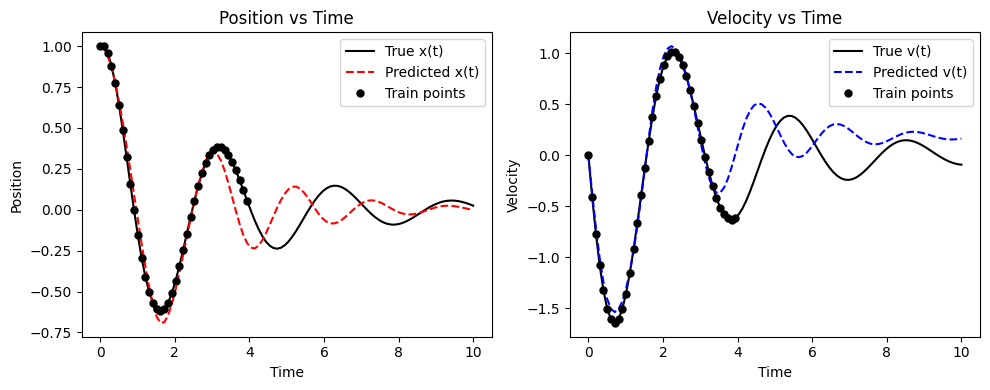

In [15]:
with torch.no_grad():
    pred_test = odeint(func, y_train_tensor[0], t_test_tensor, method='dopri5').cpu().numpy()

plt.figure(figsize=(10, 4))

# --- Position ---
plt.subplot(1, 2, 1)
plt.plot(t_test, y[:, 0], 'k-', label='True x(t)')
plt.plot(t_test, pred_test[:, 0], 'r--', label='Predicted x(t)')
plt.plot(t_train, y_train[:, 0], 'ko', label='Train points', markersize=5)
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend()
plt.title("Position vs Time")

# --- Velocity ---
plt.subplot(1, 2, 2)
plt.plot(t_test, y[:, 1], 'k-', label='True v(t)')
plt.plot(t_test, pred_test[:, 1], 'b--', label='Predicted v(t)')
plt.plot(t_train, y_train[:, 1], 'ko', label='Train points', markersize=5)
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend()
plt.title("Velocity vs Time")

plt.tight_layout()
plt.show()


Epoch    0 | Data Loss = 0.887142 | Physics Loss = 6.886589
Epoch  100 | Data Loss = 0.011652 | Physics Loss = 0.109356
Epoch  200 | Data Loss = 0.002592 | Physics Loss = 0.018231
Epoch  300 | Data Loss = 0.001415 | Physics Loss = 0.013309
Epoch  400 | Data Loss = 0.001057 | Physics Loss = 0.010081
Epoch  500 | Data Loss = 0.000869 | Physics Loss = 0.007664
Epoch  600 | Data Loss = 0.000757 | Physics Loss = 0.006065
Epoch  700 | Data Loss = 0.000692 | Physics Loss = 0.004993
Epoch  800 | Data Loss = 0.000655 | Physics Loss = 0.004220
Training time: 2583.28 seconds


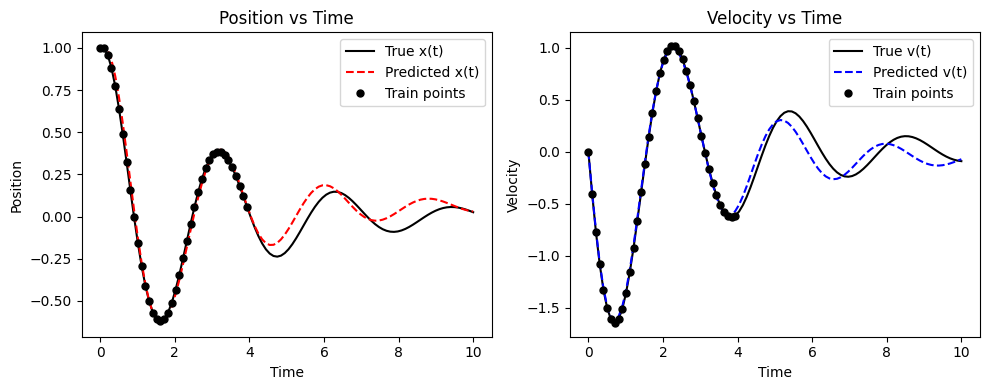

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from torchdiffeq import odeint_adjoint as odeint

# --- Assume previous setup code is here (device, data generation, etc.) ---
# Your provided setup code is fine.

# Define constants
gamma = 0.5
omega = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Your data generation code ---
t_test = np.linspace(0, 10, 100)
dt = t_test[1] - t_test[0]
y = np.zeros((len(t_test), 2))
y[0] = [1.0, 0.0]
for i in range(1, len(t_test)):
    dxdt = y[i-1, 1]
    dvdt = -2 * gamma * y[i-1, 1] - omega**2 * y[i-1, 0]
    y[i] = y[i-1] + np.array([dxdt, dvdt]) * dt
t_train = t_test[:40]
y_train = y[:40]
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).to(device)
# --- End of data generation ---


class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )
    def forward(self, t, y):
        return self.net(y)

# MODIFIED FUNCTION
def compute_physics_residual(func, t, y0, rtol, atol):
    # Pass the tolerances to the solver
    y = odeint(func, y0, t, method='dopri5', rtol=rtol, atol=atol) # <--- MODIFIED
    
    x = y[:, 0]
    v = y[:, 1]

    # Note: Calculating derivatives of the *output* of an ODE solver w.r.t time
    # is computationally expensive. A PINN-style approach would be faster here.
    dxdt = torch.gradient(x, spacing=(t,))[0]
    dvdt = torch.gradient(v, spacing=(t,))[0]

    residual = dvdt + 2 * gamma * v + omega**2 * x
    return torch.mean(residual**2)


func = ODEFunc().to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

t_train_tensor.requires_grad_(True)

# Define tolerances
rtol, atol = 1e-4, 1e-5

start_time = time.time()
for epoch in range(900):
    optimizer.zero_grad()
    
    # MODIFIED ODEINT CALL IN MAIN LOOP
    pred = odeint(func, y_train_tensor[0], t_train_tensor, method='dopri5', rtol=rtol, atol=atol) # <--- MODIFIED
    loss_data = loss_fn(pred, y_train_tensor)

    # Pass tolerances to the helper function
    loss_phy = compute_physics_residual(func, t_train_tensor, y_train_tensor[0], rtol, atol) # <--- MODIFIED

    loss = loss_data + 0.1 * loss_phy
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Data Loss = {loss_data.item():.6f} | Physics Loss = {loss_phy.item():.6f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# --- Plotting code remains the same ---
with torch.no_grad():
    pred_test = odeint(func, y_train_tensor[0], t_test_tensor, method='dopri5').cpu().numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t_test, y[:, 0], 'k-', label='True x(t)')
plt.plot(t_test, pred_test[:, 0], 'r--', label='Predicted x(t)')
plt.plot(t_train, y_train[:, 0], 'ko', label='Train points', markersize=5)
plt.xlabel("Time"); plt.ylabel("Position"); plt.legend(); plt.title("Position vs Time")
plt.subplot(1, 2, 2)
plt.plot(t_test, y[:, 1], 'k-', label='True v(t)')
plt.plot(t_test, pred_test[:, 1], 'b--', label='Predicted v(t)')
plt.plot(t_train, y_train[:, 1], 'ko', label='Train points', markersize=5)
plt.xlabel("Time"); plt.ylabel("Velocity"); plt.legend(); plt.title("Velocity vs Time")
plt.tight_layout()
plt.show()